In [1]:
import keras
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout
from tensorflow.keras.models import Model
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

from plotly.offline import init_notebook_mode

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import spectral

init_notebook_mode(connected=True)
%matplotlib inline

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


# Data Loading

In [12]:
## GLOBAL VARIABLES
dataset = 'IP'
test_ratio = 0.2
windowSize = 21

In [13]:
def loadData(name):
    data_path = os.path.join(os.getcwd(),'data')
    if name == 'IP':
        data = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
#     elif name == 'SA':
#         data = sio.loadmat(os.path.join(data_path, 'Salinas_corrected.mat'))['salinas_corrected']
#         labels = sio.loadmat(os.path.join(data_path, 'Salinas_gt.mat'))['salinas_gt']
#     elif name == 'PU':
#         data = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
#         labels = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']
    
    return data, labels

In [14]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [ ]:
# 


In [15]:
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [16]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [17]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [18]:
X, y = loadData(dataset)

print(X.shape, y.shape)

(145, 145, 200) (145, 145)


In [19]:
K = X.shape[2]

In [20]:
K = 100 if dataset == 'IP' else 15
X,pca = applyPCA(X,numComponents=K)

print(X.shape)

(145, 145, 100)


In [21]:

X, y = createImageCubes(X, y, windowSize=windowSize)


print(X.shape, y.shape)

(10249, 21, 21, 100) (10249,)


In [22]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)

print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)

(8199, 21, 21, 100) (2050, 21, 21, 100) (8199,) (2050,)


Xtrain, Xvalid, ytrain, yvalid = splitTrainTestSet(Xtrain, ytrain, 0.3333)

Xtrain.shape, Xvalid.shape, ytrain.shape, yvalid.shape

# Model and Training

In [23]:
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, K, 1)
Xtrain.shape

(8199, 21, 21, 100, 1)

In [24]:
print(ytrain.shape)

(8199,)


In [25]:
ytrain = np_utils.to_categorical(ytrain)
ytest = np_utils.to_categorical(ytest)
ytrain.shape

(8199, 16)

Xvalid = Xvalid.reshape(-1, windowSize, windowSize, K, 1)
Xvalid.shape

yvalid = np_utils.to_categorical(yvalid)
yvalid.shape

In [26]:
S = windowSize
L = K
output_units = 16
print(S,S,L)

21 21 100


In [29]:
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization,\
                                    Add, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model

def relu_bn(inputs: Tensor) -> Tensor:
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn

def residual_block(x: Tensor, downsample: bool, filters: int, kernel_size: int = 3) -> Tensor:
    y = Conv2D(kernel_size=kernel_size,
               strides= (1 if not downsample else 2),
               filters=filters,
               padding="same")(x)
    y = relu_bn(y)
    y = Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)

    if downsample:
        x = Conv2D(kernel_size=1,
                   strides=2,
                   filters=filters,
                   padding="same")(x)
    out = Add()([x, y])
    out = relu_bn(out)
    return out

def create_res_net():
    
    inputs = Input(shape=(S, S, L))
    num_filters = 16
    
    t = BatchNormalization()(inputs)
    t = Conv2D(kernel_size=3,
               strides=1,
               filters=num_filters,
               padding="same")(t)
    t = relu_bn(t)
    
    num_blocks_list = [2, 5,2]
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            t = residual_block(t, downsample=(j==0 and i!=0), filters=num_filters)
        num_filters *= 2
    
    t = AveragePooling2D(4)(t)
    t = Flatten()(t)
    outputs = Dense(16, activation='softmax')(t)
    
    model = Model(inputs, outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [33]:
# from tensorflow.keras.datasets import cifar10
# from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
# import datetime
# import os


# model = create_res_net() # or create_plain_net()
# model.summary()
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import datetime
import os

# (x_train, y_train), (x_test, y_test) = cifar10.load_data()
(x_train, y_train), (x_test, y_test) = (Xtrain,ytrain), (Xtest,ytest) 

model = create_res_net() # or create_plain_net()
model.summary()

timestr = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
name = 'best-model_res.hdf5' # or 'cifar-10_plain_net_30-'+timestr

checkpoint_path = "checkpoints/"+name+"/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
os.system('mkdir {}'.format(checkpoint_dir))

# save model after each epoch
# cp_callback = ModelCheckpoint(
#     filepath=checkpoint_path,
#     verbose=1
# )
# tensorboard_callback = TensorBoard(
#     log_dir='tensorboard_logs/'+name,
#     histogram_freq=1
# )

model.fit(
    x=x_train,
    y=y_train,
    epochs=30,
    verbose=1,
    validation_data=(x_test, y_test),
    batch_size=256,
#     callbacks=[cp_callback, tensorboard_callback]
)


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 21, 21, 100) 0                                            
__________________________________________________________________________________________________
batch_normalization_80 (BatchNo (None, 21, 21, 100)  400         input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_84 (Conv2D)              (None, 21, 21, 16)   14416       batch_normalization_80[0][0]     
__________________________________________________________________________________________________
re_lu_76 (ReLU)                 (None, 21, 21, 16)   0           conv2d_84[0][0]                  
____________________________________________________________________________________________

Epoch 1/30
33/33 [==============================] - 35s 971ms/step - loss: 1.9673 - accuracy: 0.4045 - val_loss: 2.7952 - val_accuracy: 0.1210
Epoch 2/30
33/33 [==============================] - 29s 871ms/step - loss: 0.4044 - accuracy: 0.8877 - val_loss: 1.4709 - val_accuracy: 0.5317
Epoch 3/30
33/33 [==============================] - 31s 928ms/step - loss: 0.1440 - accuracy: 0.9652 - val_loss: 1.0427 - val_accuracy: 0.6780
Epoch 4/30
33/33 [==============================] - 33s 990ms/step - loss: 0.1094 - accuracy: 0.9720 - val_loss: 0.7957 - val_accuracy: 0.7683
Epoch 5/30
33/33 [==============================] - 29s 885ms/step - loss: 0.0999 - accuracy: 0.9713 - val_loss: 0.4081 - val_accuracy: 0.8580
Epoch 6/30
33/33 [==============================] - 28s 862ms/step - loss: 0.0436 - accuracy: 0.9906 - val_loss: 0.2967 - val_accuracy: 0.9005
Epoch 7/30
33/33 [==============================] - 28s 844ms/step - loss: 0.0192 - accuracy: 0.9972 - val_loss: 0.2500 - val_accuracy: 0.9127

In [ ]:
# ## input layer
# input_layer = Input((S, S, L, 1))

# ## convolutional layers

# conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
# conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)
# print(conv_layer3._keras_shape)
# conv3d_shape = conv_layer3._keras_shape
# conv_layer3 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)
# conv_layer4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(conv_layer3)

# flatten_layer = Flatten()(conv_layer4)

# ## fully connected layers
# dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
# dense_layer1 = Dropout(0.4)(dense_layer1)
# dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
# dense_layer2 = Dropout(0.4)(dense_layer2)
# output_layer = Dense(units=output_units, activation='softmax')(dense_layer2)

In [ ]:
# define the model with input layer and output layer
# model = Model(inputs=input_layer, outputs=output_layer)

In [ ]:
model.summary()

In [34]:
# compiling the model
adam = Adam(learning_rate=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [35]:
# checkpoint
filepath = "best-model_res.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, mode='max')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=30, callbacks=callbacks_list,validation_data=(x_test, y_test))

# Validation

In [37]:
# load best weights
model.load_weights("best-model_res.hdf5")
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [38]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, K, 1)
Xtest.shape

(2050, 21, 21, 100, 1)

In [39]:
# ytest = np_utils.to_categorical(ytest)
ytest.shape

(2050, 16)

In [40]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)
# y_pred_test = np_utils.to_categorical(y_pred_test)
# print(y_pred_test.shape)


In [41]:
print(y_pred_test[10])
classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

10
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      0.98      0.99       286
           2       0.93      1.00      0.97       166
           3       1.00      0.96      0.98        47
           4       1.00      0.87      0.93        97
           5       0.99      1.00      0.99       146
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00        96
           8       0.80      1.00      0.89         4
           9       0.99      0.98      0.99       194
          10       0.99      0.99      0.99       491
          11       0.99      0.94      0.97       119
          12       0.93      1.00      0.96        41
          13       1.00      1.00      1.00       253
          14       0.87      1.00      0.93        77
          15       0.84      0.84      0.84        19

    accuracy                           0.98      2050
   macro avg       0.96

In [42]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [43]:
def reports (X_test,y_test,name):
    #start = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)
    if name == 'IP':
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
    elif name == 'SA':
        target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    elif name == 'PU':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']
    
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [44]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest,dataset)
classification = str(classification)
confusion = str(confusion)
file_name = "classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

65/65 [==============================] - 2s 19ms/step - loss: 0.0531 - accuracy: 0.9791


In [45]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [46]:
# load the original image
X, y = loadData(dataset)

In [47]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize
numComponents = K

In [48]:
X,pca = applyPCA(X, numComponents=numComponents)

In [49]:
X = padWithZeros(X, PATCH_SIZE//2)

In [50]:
# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1

/usr/local/lib/python3.9/site-packages/spectral/graphics/spypylab.py:58: MatplotlibDeprecationWarning:


The keymap.all_axes rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.

/usr/local/lib/python3.9/site-packages/spectral/graphics/spypylab.py:936: MatplotlibDeprecationWarning:

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.



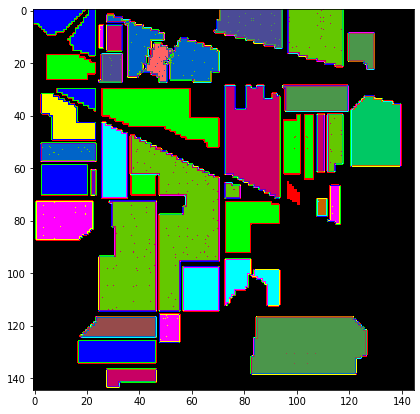

In [51]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))

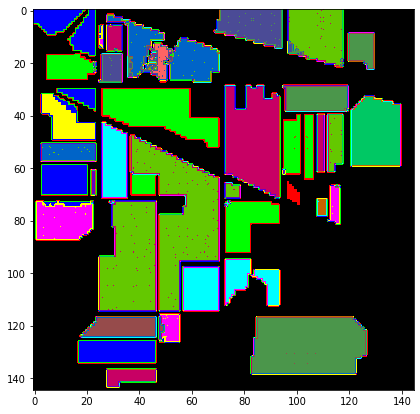

In [52]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))

In [53]:
spectral.save_rgb("predictions.jpg", outputs.astype(int), colors=spectral.spy_colors)

spectral.save_rgb(str(dataset)+"_ground_truth.jpg", y, colors=spectral.spy_colors)